In [1]:
import tqdm
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# PyTorch
import torch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses

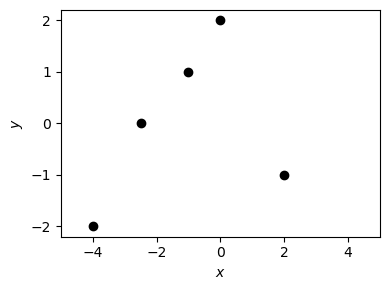

In [3]:
X_train_numpy, y_train_numpy = np.array([[-4], [-2.5], [-1], [0], [2]]), np.array([-2, 0, 1, 2, -1])

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_train_numpy, y_train_numpy, color='#000000')
ax.set_xlim([-5, 5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
X_train, y_train = torch.tensor(X_train_numpy, dtype=torch.float32), torch.tensor(y_train_numpy, dtype=torch.float32).view(-1, 1)

In [5]:
lr, weight_decay = 1e-2, 1e-6
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1)
criterion = losses.ERMLoss(criterion=torch.nn.MSELoss())
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:
train_losses = []
for epoch in tqdm.tqdm(range(10_000)):
    model.zero_grad()
    params = torch.nn.utils.parameters_to_vector(model.parameters())
    logits = model(X_train)
    losses_dict = criterion(y_train, logits, params, len(X_train))
    losses_dict['loss'].backward()
    optimizer.step()
    train_losses.append(losses_dict['loss'].item())

100%|██████████| 10000/10000 [00:21<00:00, 458.03it/s]


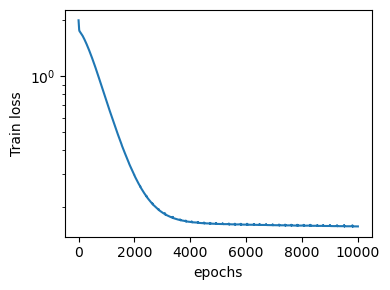

In [7]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(range(len(train_losses)), train_losses)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

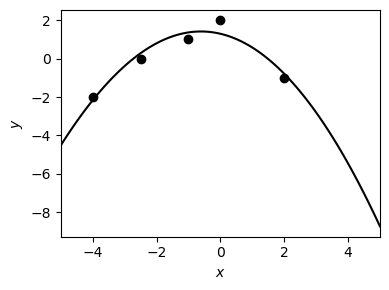

In [8]:
with torch.no_grad():
    x = torch.linspace(start=-5, end=5, steps=100)
    z = model(x.view(-1, 1))
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_train_numpy, y_train_numpy, color='#000000')
ax.plot(x, z, color='#000000')
ax.set_xlim([-5, 5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [9]:
def flatten_params(model, excluded_params=['lengthscale', 'outputscale', 'sigma_param']):
    return torch.cat([param.view(-1) for name, param in model.named_parameters() if name not in excluded_params])

In [10]:
lr = 1e-2
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
setattr(model, 'linear', layers.VariationalLinear(model.linear, model.sigma_param))

model.lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
torch.nn.utils.parametrize.register_parametrization(model, 'lengthscale', torch.nn.Softplus())
model.outputscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
torch.nn.utils.parametrize.register_parametrization(model, 'outputscale', torch.nn.Softplus())

d = len(flatten_params(model))
criterion = losses.DataEmphasizedELBo(d/len(X_train), model.sigma_param, criterion=torch.nn.MSELoss())
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
train_losses = []
for epoch in tqdm.tqdm(range(10_000)):
    model.zero_grad()
    params = flatten_params(model)
    logits = model(X_train)
    losses_dict = criterion(y_train, logits, params, len(X_train))
    losses_dict['loss'].backward()
    optimizer.step()
    train_losses.append(losses_dict['loss'].item())

100%|██████████| 10000/10000 [01:18<00:00, 126.86it/s]


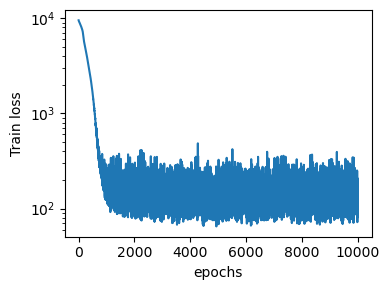

In [12]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(range(len(train_losses)), train_losses)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

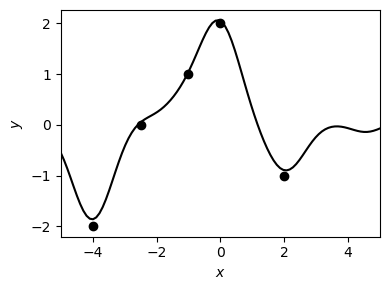

In [13]:
model.eval()
with torch.no_grad():
    x = torch.linspace(start=-5, end=5, steps=100)
    z = model(x.view(-1, 1))
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_train_numpy, y_train_numpy, color='#000000')
ax.plot(x, z, color='#000000')
ax.set_xlim([-5, 5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

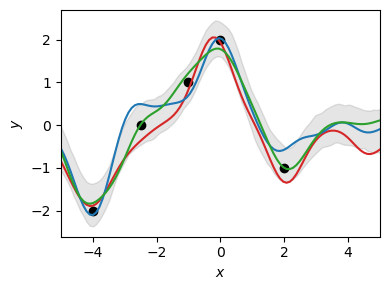

In [14]:
model.train()
with torch.no_grad():
    z = []
    for _ in range(100):
        x = torch.linspace(start=-5, end=5, steps=100)
        z.append(model(x.view(-1, 1)).squeeze(1))
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_train_numpy, y_train_numpy, color='#000000')
ax.plot(x, torch.stack(z)[0], color='#D62728')
ax.plot(x, torch.stack(z)[1], color='#1F77B4')
ax.plot(x, torch.stack(z)[2], color='#2CA02C')
ax.fill_between(
    x, 
    torch.quantile(torch.stack(z), 0.025, dim=0),
    torch.quantile(torch.stack(z), 0.975, dim=0),
    alpha=0.1,
    color='#000000',
)
ax.set_xlim([-5, 5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()